In [ ]:
from sklearn.utils import shuffle
from scipy.stats import mode
from random import sample
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
import numpy as np

class TreeNode:
    def __init__(self, featureIndex=None, threshold=None, left=None, right=None, value=None, infoGain=None,label=None, prob=None,class_distribution=None):
        self.featureIndex = featureIndex
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value  # Value assigned for leaf nodes
        self.label=label
        self.infoGain = infoGain  # Information gain at the node
        self.class_distribution = class_distribution  # Class distribution at the node (for leaf nodes)
        self.prob = prob  # Class distribution at the node (for leaf nodes)

class DecisionTree:
    def __init__(self, K=None, maxDepth=None):
        self.maxDepth = maxDepth  # Maximum depth of the tree
        self.tree = None            # Root node of the decision tree
        self.K = K

    def fit(self, X, y):
        root = self._growTree(X, y)
        self.root=root
        return root


    def predict(self, X):
        return np.array([self._traverseTree_prob(x, self.root) for x in X])

    def _growTree(self, X, y, depth=0):
        numSamples, numFeatures = X.shape
        uniqueClasses = np.unique(y)

        # Create a leaf node if stopping criteria are met
        if (len(uniqueClasses) == 1) or (depth == self.maxDepth):
            cuns = np.bincount(y)
            while int(cuns.shape[0]) < self.K:
                cuns = np.append(cuns, np.array([0]))
            return TreeNode(label=np.argmax(cuns), prob=cuns/np.sum(cuns))

        # Find the best split
        bestFeature, bestThreshold, bestInfoGain = self._findBestSplit(X, y, numSamples, numFeatures)

        # Create a leaf node if no good split was found
        if bestFeature is None:
            prob = self._prob(y)
            return TreeNode(value=self._mostCommonLabel(y), prob=prob)

        # Split the dataset
        leftIndices, rightIndices = self._split(X[:, bestFeature], bestThreshold)
        leftSubtree = self._growTree(X[leftIndices, :], y[leftIndices], depth + 1)
        rightSubtree = self._growTree(X[rightIndices, :], y[rightIndices], depth + 1)

        # Return a decision node
        return TreeNode(bestFeature, bestThreshold, leftSubtree, rightSubtree, infoGain=bestInfoGain)
    def _traverseTree_prob(self, x, node):
        if node.label is not None:
            return node.prob

        if x[node.featureIndex] < node.threshold:
            return self._traverseTree_prob(x, node.left)
        else:
            return self._traverseTree_prob(x, node.right)
    def _traverseTree(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.featureIndex] <= node.threshold:
            return self._traverseTree(x, node.left)
        return self._traverseTree(x, node.right)

    def _findBestSplit(self, X, y, numSamples, numFeatures):
        bestGain = -1
        splitIndex, splitThreshold = None, None
        for featureIndex in range(numFeatures):
            featureValues = X[:, featureIndex]
            possibleThresholds = np.unique(featureValues).astype(float)  # Convert to float explicitly
            for threshold in possibleThresholds:
                gain = self._calculateInformationGain(y, featureValues, threshold)
                if gain > bestGain:
                    bestGain = gain
                    splitIndex = featureIndex
                    splitThreshold = threshold
        return splitIndex, splitThreshold, bestGain

    def _calculateInformationGain(self, y, featureValues, threshold):
        # Parent Entropy
        parentEntropy = self._calculateEntropy(y)

        # Generate split
        leftIndices, rightIndices = self._split(featureValues, threshold)

        if len(leftIndices) == 0 or len(rightIndices) == 0:
            return 0

        # Weighted average of child entropies
        n = len(y)
        nLeft, nRight = len(leftIndices), len(rightIndices)
        eLeft, eRight = self._calculateEntropy(y[leftIndices]), self._calculateEntropy(y[rightIndices])
        childEntropy = (nLeft / n) * eLeft + (nRight / n) * eRight

        # Information gain is the difference in entropy before vs. after the split
        ig = parentEntropy - childEntropy
        return ig

    def _calculateEntropy(self, y):
        hist = np.bincount(y)
        probabilities = hist / len(y)
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

    def _split(self, featureValues, threshold):
        # Split the dataset based on the given threshold
        leftIndices = np.argwhere(featureValues <= threshold).flatten()
        rightIndices = np.argwhere(featureValues > threshold).flatten()

        # Ensure indices do not go out of bounds
        leftIndices = np.clip(leftIndices, 0, len(featureValues) - 1)
        rightIndices = np.clip(rightIndices, 0, len(featureValues) - 1)

        return leftIndices, rightIndices

    def _prob(self, y):
        # Calculate class distribution for a node
        classCounts = np.bincount(y)
        totalSamples = len(y)
        return {classLabel: count / totalSamples for classLabel, count in enumerate(classCounts)}

    def _mostCommonLabel(self, y):
        return np.bincount(y).argmax()

    def displayTree(self, node=None, depth=0, featureNames=None):
        if node is None:
            node = self.root

        if node.label is not None:  # Leaf node
            print("\t" * depth + f"Leaf: Class={node.label}, Distribution={node.prob}")
        else:
            featureName = featureNames[node.featureIndex] if featureNames else f"Feature {node.featureIndex}"
            print("\t" * depth + f"[{featureName} <= {node.threshold:.2f}, Info Gain={node.infoGain:.4f}]")
            self.displayTree(node.left, depth + 1, featureNames)
            self.displayTree(node.right, depth + 1, featureNames)

    def print_tree(self, node):
        if node.left is None and node.right is None:
            print("(Leaf node) Probability Distribution=", node.prob)
            return
        print("(Internal node) Information Gain=", node.infoGain, ", Feature=", node.featureIndex, ", Threshold=", node.threshold)
        self.print_tree(node.left)
        self.print_tree(node.right)
        return


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Custom Decision Tree implementation (as previously defined)
# Assume it's implemented here or imported from another module

def plotDecisionBoundaries(features, labels, model, title="Decision Boundary"):
    # Create a mesh grid covering the data space
    xMin, xMax = features[:, 0].min() - 0.1, features[:, 0].max() + 0.1
    yMin, yMax = features[:, 1].min() - 0.1, features[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(xMin, xMax, 100), np.linspace(yMin, yMax, 100))

    # Predict class labels for each point in the mesh grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Check the shape of Z and reshape accordingly
    if Z.ndim == 1:
        Z = Z.reshape(xx.shape)
    else:
        Z = np.argmax(Z, axis=1).reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.brg)
    plt.scatter(features[:, 0], features[:, 1], c=labels, s=40, cmap=plt.cm.brg, edgecolors='k')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

In [ ]:
# def plotDecisionBoundaries(clf, X, Y, ax, title, cmap='Paired_r'):
#     h = 0.02
#     x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
#     y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                          np.arange(y_min, y_max, h))
#     Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
#     Z = Z.reshape(xx.shape)

#     ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)
#     ax.contour(xx, yy, Z, colors='k', linewidths=0.7)
#     ax.scatter(X[:,0], X[:,1], c=Y, cmap=cmap, edgecolors='k')
#     ax.set_title(title, fontsize = 10)

In [ ]:
def plot_decision_boundary( X, Y, clf,ax, title, cmap='Paired_r'):
    h = 0.02
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        # Check the shape of Z and reshape accordingly
    if Z.ndim == 1:
        Z = Z.reshape(xx.shape)
    else:
        Z = np.argmax(Z, axis=1).reshape(xx.shape)

    ax.contourf(xx, yy, Z, cmap=plt.cm.brg, alpha=0.25)
    ax.contour(xx, yy, Z, colors='k', linewidths=0.7)
    ax.scatter(X[:,0], X[:,1], c=Y, cmap=plt.cm.brg, edgecolors='k')
    ax.set_title(title, fontsize = 10)

In [ ]:
def classify_DT(X, y, K, dep, dataset):
    X, y = shuffle(X, y, random_state=0)
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.3)

    X_class = [None] * K
    for j in range(K):
        X_class[j] = []
    for i in range(K):
        present = (y == i)
        X_class[i] = X[present]

    # print(len(X_class))

    no_bag = 10
    train_size = len(X)

    dt = DecisionTree(K, dep)
    dt.fit(X, y)
    y_prob = dt.predict(X_test)
    y_pred = np.array([np.argmax(cuns) for cuns in y_prob])
    # print(accuracy_score(y_test, y_pred))

    X_bag = [None] * no_bag
    y_bag = [None] * no_bag

    for j in range(no_bag):
        X_bag[j] = []
        y_bag[j] = []

    for i in range(K):
        cnt = 0
        mysamp = []
        while cnt + no_bag < len(X_class[i]):
            mysamp.append(sample(range(no_bag), no_bag))
            cnt += no_bag
        mysamp.append(sample(range(no_bag), len(X_class[i])-cnt))
        mysamp=[element for sublist in mysamp for element in sublist]
        for j in range(len(X_class[i])):
            X_bag[mysamp[j]].append(X_class[i][j])
            y_bag[mysamp[j]].append(i)

    # dt.print_tree(dt.tree)

    barWidth = 0.25
    class_dist = [None] * K
    br = [None] * K
    for j in range(K):
        class_dist[j] = []
        br[j] = []
    br[0] = np.arange(10)
    for j in range(K-1):
        br[j+1] = [x + barWidth for x in br[j]]

    for i in range(no_bag):
        for j in range(K):
            class_dist[j].append(np.count_nonzero(np.array(y_bag[i]) == j)/len(y_bag[i]))
#             print("Probability of class ", j, " for bag ", i, "=", np.count_nonzero(np.array(y_bag[i]) == j)/len(y_bag[i]))

    for k in range(K):
        plt.bar(br[k], class_dist[k], width = barWidth, label=str(k))

    plt.xlabel('Bag', fontsize = 15)
    plt.ylabel('Probability Distribution', fontsize = 15)
    plt.xticks([r + barWidth for r in range(10)], range(10))
    plt.title('Bags for {0} Dataset'.format(dataset))
    plt.legend()
    plt.show()

    fig, ax = plt.subplots()
    fig.set_size_inches(4,4)
    plot_decision_boundary(X, y, dt, ax,"Decision boundary on whole data")
    plt.show()
    accuracies = []
    # dts = []
    y_probs = []

    fig, ax = plt.subplots(2, 5)
    fig.set_size_inches(14, 5)
    fig.subplots_adjust(hspace=0.4, wspace=0.2)

    for i in range(no_bag):
        dt = DecisionTree(K,dep)
        X_bag[i], y_bag[i] = shuffle(X_bag[i], y_bag[i], random_state=0)
    #     X_train, X_test, y_train, y_test = train_test_split(X_bag[i], y_bag[i], test_size=0.3)
        dt.fit(np.array(X_bag[i]), np.array(y_bag[i]))
        y_prob = dt.predict(X_test)
        y_probs.append(y_prob)
        plot_decision_boundary(np.array(X_bag[i]), np.array(y_bag[i]),dt, ax[int(i/5)][i%5], "Decision boundary on bag " + str(i+1))
    #     accuracies.append(accuracy_score(y_test, y_pred))

    # val, count = mode(y_preds, axis = 0)
    # y_pred is the final predictions
    y_pred = np.array([])

    for j in range(len(X_test)):
        sum_prob = np.zeros(K)
        for i in range(no_bag):
            # Probability of j-th sample in i-th bag
            cur_prob = y_probs[i][j]
            sum_prob += cur_prob
        sum_prob = sum_prob/no_bag
        prediction = np.argmax(sum_prob)
        y_pred = np.append(y_pred, prediction)

    print("Accuracy in Random forest: ",accuracy_score(y_test, y_pred))

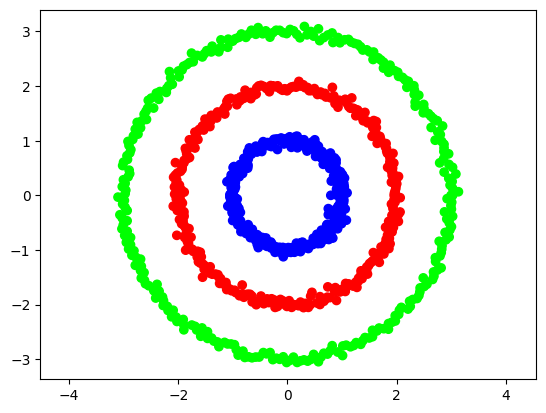

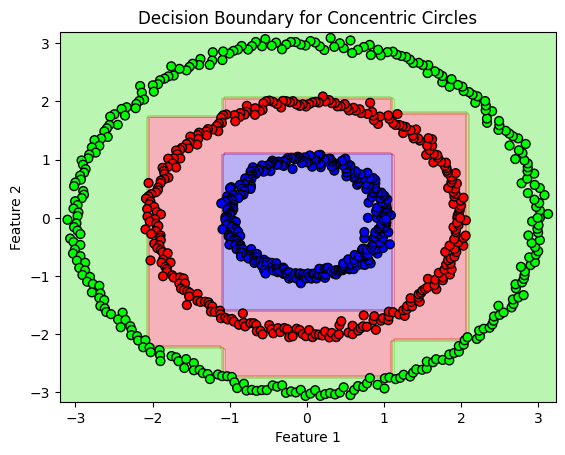

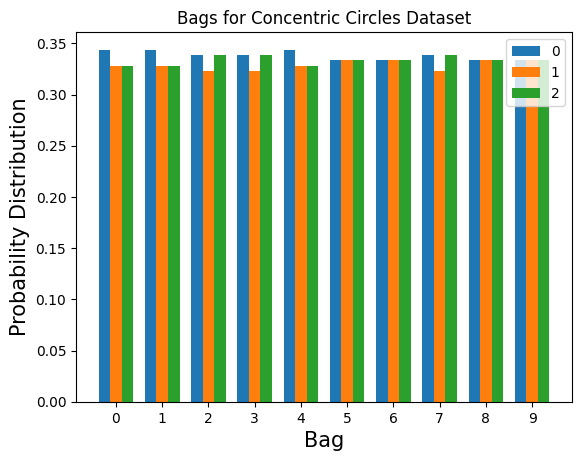

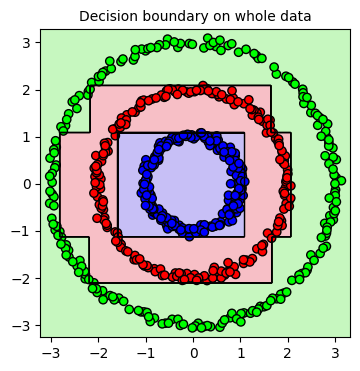

Accuracy in Random forest:  0.9481481481481482
(Internal node) Information Gain= 0.16341629742542163 , Feature= 0 , Threshold= 1.0906003147674648
(Internal node) Information Gain= 0.3258819206128831 , Feature= 0 , Threshold= -1.108860340407103
(Internal node) Information Gain= 0.4765868095885044 , Feature= 0 , Threshold= -2.0927150453084207
(Leaf node) Probability Distribution= [0. 0. 1.]
(Internal node) Information Gain= 0.29874183238676255 , Feature= 1 , Threshold= -2.228932309690911
(Leaf node) Probability Distribution= [0. 0. 1.]
(Internal node) Information Gain= 0.6142910730156772 , Feature= 1 , Threshold= 1.7199969946387506
(Leaf node) Probability Distribution= [0. 1. 0.]
(Leaf node) Probability Distribution= [0. 0. 1.]
(Internal node) Information Gain= 0.3236050228886369 , Feature= 1 , Threshold= -1.6132156524119234
(Internal node) Information Gain= 0.9722080563599758 , Feature= 1 , Threshold= -2.7198916176706867
(Leaf node) Probability Distribution= [0. 0. 1.]
(Leaf node) Proba

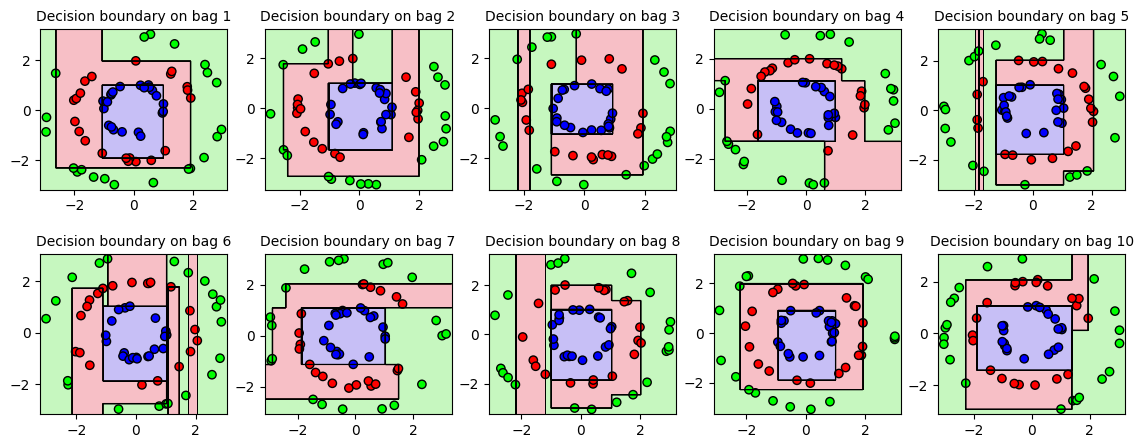

In [ ]:
# Generate Concentric Circles dataset

import numpy as np
import matplotlib.pyplot as plt
# Set the number of samples and noise level
n = 300
noise = 0.06

# Generate the data
theta = np.linspace(0, 2*np.pi, n)
r1 = np.random.normal(0, noise, n) + 1
r2 = np.random.normal(0, noise, n) + 2
r3 = np.random.normal(0, noise, n) + 3
# Convert polar coordinates to Cartesian coordinates for each circle
x1 = r1 * np.cos(theta)
y1 = r1 * np.sin(theta)
x2 = r2 * np.cos(theta)
y2 = r2 * np.sin(theta)
x3 = r3 * np.cos(theta)
y3 = r3 * np.sin(theta)

# Concatenate the data for all circles into one array
# Each row represents a sample, and the two columns represent the x and y coordinates
XCircles = np.vstack([np.column_stack([x1, y1]),
                       np.column_stack([x2, y2]),
                       np.column_stack([x3, y3])])

# Create labels for each circle
yCircles = np.concatenate([np.zeros(n), np.ones(n), 2*np.ones(n)]).astype(int)

# Now XCircles is shaped correctly with samples as rows and features as columns,
# and yCircles is a 1D array of labels.

# Plot the corrected data
plt.scatter(XCircles[:, 0], XCircles[:, 1], c=yCircles, cmap=plt.cm.brg)  # Now this should work correctly
plt.axis('equal')
plt.show()

# Instantiate and train the decision tree
tree_circles = DecisionTree(3,10)
root = tree_circles.fit(XCircles, yCircles)
# Plot decision boundaries
plotDecisionBoundaries(XCircles, yCircles, tree_circles, title="Decision Boundary for Concentric Circles")
plt.show()

classify_DT(XCircles, yCircles.astype(int), 3, 10, "Concentric Circles")



tree_circles.print_tree(root)

In [ ]:
# Initialize the DecisionTree
treeCircle = DecisionTree(3,10)
treeCircle.fit(XCircles, yCircles)

# Display the tree
print("\nDecision Tree for Concentric Circles Dataset:")
treeCircle.displayTree()



Decision Tree for Concentric Circles Dataset:
[Feature 0 <= 1.09, Info Gain=0.1634]
	[Feature 0 <= -1.11, Info Gain=0.3259]
		[Feature 0 <= -2.09, Info Gain=0.4766]
			Leaf: Class=2, Distribution=[0. 0. 1.]
			[Feature 1 <= -2.23, Info Gain=0.2987]
				Leaf: Class=2, Distribution=[0. 0. 1.]
				[Feature 1 <= 1.72, Info Gain=0.6143]
					Leaf: Class=1, Distribution=[0. 1. 0.]
					Leaf: Class=2, Distribution=[0. 0. 1.]
		[Feature 1 <= -1.61, Info Gain=0.3236]
			[Feature 1 <= -2.72, Info Gain=0.9722]
				Leaf: Class=2, Distribution=[0. 0. 1.]
				Leaf: Class=1, Distribution=[0. 1. 0.]
			[Feature 1 <= 1.08, Info Gain=0.7828]
				Leaf: Class=0, Distribution=[1. 0. 0.]
				[Feature 1 <= 2.09, Info Gain=0.9683]
					Leaf: Class=1, Distribution=[0. 1. 0.]
					Leaf: Class=2, Distribution=[0. 0. 1.]
	[Feature 0 <= 2.06, Info Gain=0.4468]
		[Feature 1 <= -2.10, Info Gain=0.3060]
			Leaf: Class=2, Distribution=[0. 0. 1.]
			[Feature 1 <= 1.78, Info Gain=0.6500]
				Leaf: Class=1, Distribution

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Assuming you have imported or defined DecisionTree class
# Replace this with the actual DecisionTree class you are using

# Split the data
X_circles_train, X_circles_test, y_circles_train, y_circles_test = train_test_split(XCircles, yCircles, test_size=0.3, random_state=42)

# Initialize and train the classifier
tree_circles = DecisionTree(10)
tree_circles.fit(X_circles_train, y_circles_train)

# Predict probabilities on test data
y_circles_pred_proba = tree_circles.predict(X_circles_test)

# Convert probabilities to class labels
y_circles_pred = np.argmax(y_circles_pred_proba, axis=1)

# Compute accuracy
circles_accuracy = accuracy_score(y_circles_test, y_circles_pred)
print(f"Accuracy for Concentric Circles Dataset: {circles_accuracy:.2f}")


Accuracy for Concentric Circles Dataset: 0.96


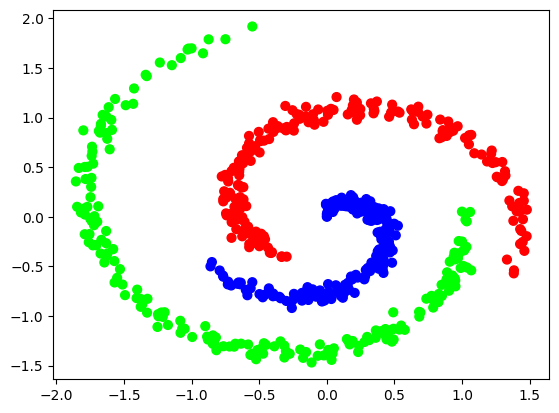

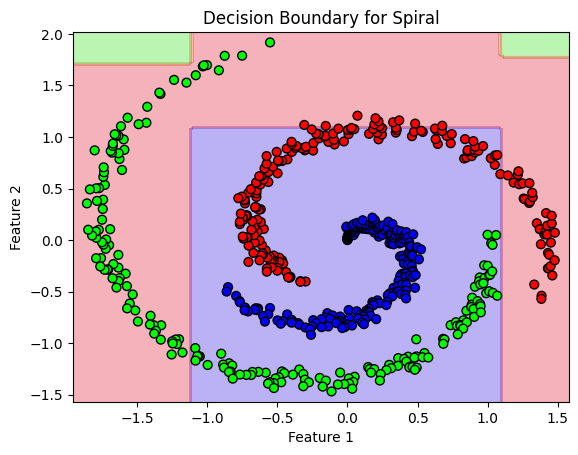

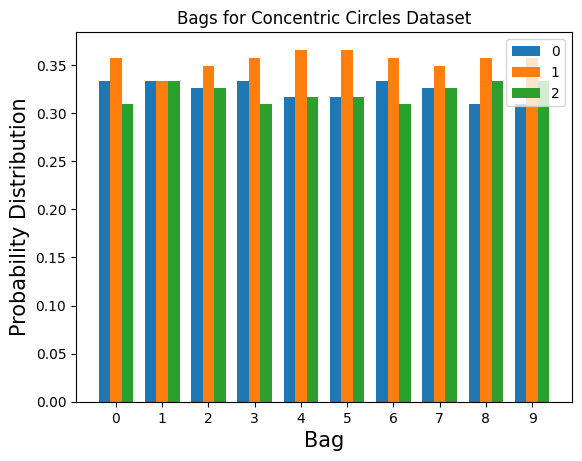

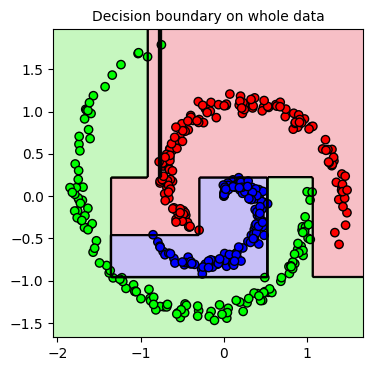

Accuracy in Random forest:  0.8833333333333333
(Internal node) Information Gain= 0.16341629742542163 , Feature= 0 , Threshold= 1.0906003147674648
(Internal node) Information Gain= 0.3258819206128831 , Feature= 0 , Threshold= -1.108860340407103
(Internal node) Information Gain= 0.4765868095885044 , Feature= 0 , Threshold= -2.0927150453084207
(Leaf node) Probability Distribution= [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(Internal node) Information Gain= 0.29874183238676255 , Feature= 1 , Threshold= -2.228932309690911
(Leaf node) Probability Distribution= [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(Internal node) Information Gain= 0.6142910730156772 , Feature= 1 , Threshold= 1.7199969946387506
(Leaf node) Probability Distribution= [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(Leaf node) Probability Distribution= [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(Internal node) Information Gain= 0.3236050228886369 , Feature= 1 , Threshold= -1.6132156524119234
(Internal node) Information Gain= 0.9722080563599758 , Feature= 1 , Threshold= -2

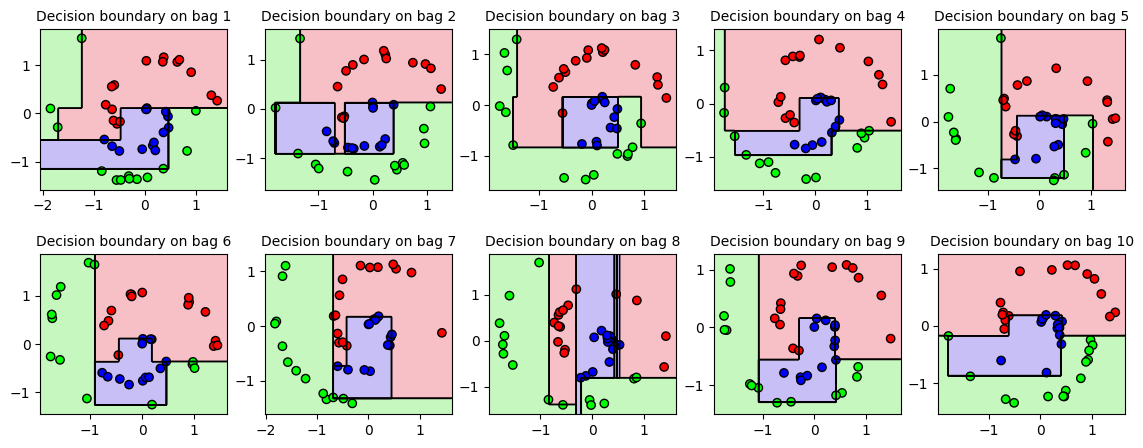

In [ ]:
# Generate Spiral dataset
import numpy as np
import matplotlib.pyplot as plt
N = 200 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
XSpiral = np . zeros (( N *K , D ) ) # data matrix ( each row = single example )
ySpiral = np . zeros ( N *K , dtype ='uint8') # class labels
for j in range ( K ) :
    ix = range (N *j , N *( j +1) )
    r = np . linspace (0.0 ,1 , N ) # radius
    r = r + j *0.5
    # print (r)

    t = np . linspace ( j *4 ,( j +1) *4 , N ) + np . random . randn ( N ) *0.2 # theta
    # print (t)
    XSpiral [ ix ] = np . c_ [ r * np . sin ( t ) , r * np . cos ( t ) ]
    ySpiral [ ix ] = j

spiral4 = np . column_stack (( XSpiral , ySpiral ) )
 #np. savetxt (" spiral5 .csv" , spiral4 , delimiter =" ," , header ="x,y, label " , comments="" , fmt = '%.5f ')
# lets visualize the data :
plt . scatter ( XSpiral [: , 0] , XSpiral [: , 1] , c =ySpiral , s =40 , cmap ='brg')
plt . show ()


# Plot decision boundaries
# Instantiate and train the decision tree
tree_spiral = DecisionTree(10)
root = tree_spiral.fit(XCircles, yCircles)
# Plot decision boundaries
plotDecisionBoundaries(XSpiral, ySpiral, tree_spiral, title="Decision Boundary for Spiral")
plt.show()

classify_DT(XSpiral, ySpiral.astype(int), 3, 10, "Concentric Circles")


tree_spiral.print_tree(root)

In [ ]:
# Initialize the DecisionTree
treeSpiral = DecisionTree(10)
treeSpiral.fit(XSpiral, ySpiral)

# Display the tree
print("\nDecision Tree for  Spiral Dataset:")
treeSpiral.displayTree()



Decision Tree for  Spiral Dataset:
[Feature 1 <= 0.22, Info Gain=0.3106]
	[Feature 1 <= -0.96, Info Gain=0.3386]
		Leaf: Class=2, Distribution=[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
		[Feature 0 <= -1.33, Info Gain=0.2801]
			Leaf: Class=2, Distribution=[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
			[Feature 0 <= 0.52, Info Gain=0.5068]
				[Feature 0 <= -0.30, Info Gain=0.4298]
					[Feature 1 <= -0.46, Info Gain=0.9353]
						Leaf: Class=0, Distribution=[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
						Leaf: Class=1, Distribution=[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
					Leaf: Class=0, Distribution=[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
				[Feature 0 <= 1.07, Info Gain=0.9393]
					Leaf: Class=2, Distribution=[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
					Leaf: Class=1, Distribution=[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
	[Feature 0 <= -0.87, Info Gain=0.7053]
		Leaf: Class=2, Distribution=[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
		[Feature 1 <= 1.21, Info Gain=0.1126]
			Leaf: Class=1, Distribution=[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
			Leaf: Class=2, 

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Assuming you have imported or defined DecisionTree class
# Replace this with the actual DecisionTree class you are using

# Split the data
X_spiral_train, X_spiral_test, y_spiral_train, y_spiral_test = train_test_split(XSpiral, ySpiral, test_size=0.3, random_state=42)

# Initialize and train the classifier
tree_spiral = DecisionTree(5)
tree_spiral.fit(X_spiral_train, y_spiral_train)

# Predict on test data
y_spiral_pred = tree_spiral.predict(X_spiral_test)
# Convert probabilities to class labels
y_spiral_pred = np.argmax(y_spiral_pred, axis=1)

# Compute accuracy
spiral_accuracy = accuracy_score(y_spiral_test, y_spiral_pred)
print(f"Accuracy for Balanced Spiral Dataset: {spiral_accuracy:.2f}")


Accuracy for Balanced Spiral Dataset: 0.97


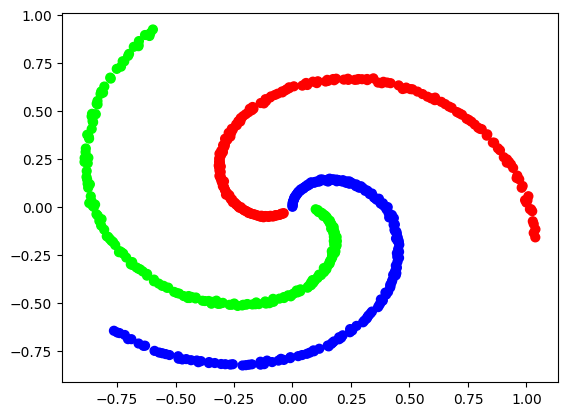

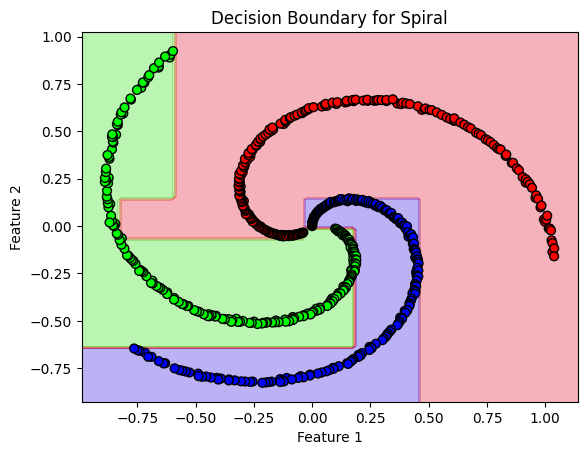

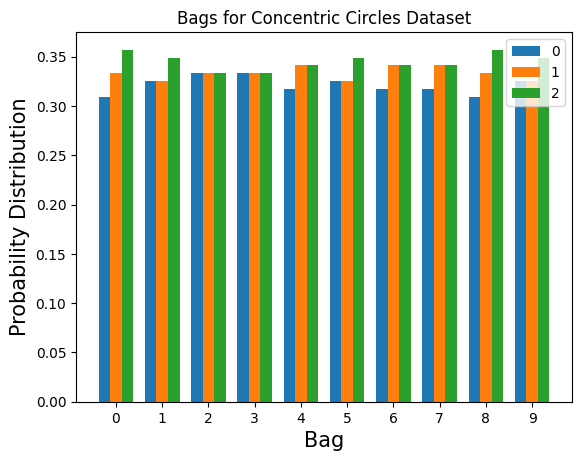

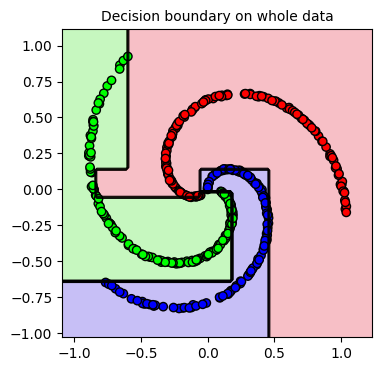

Accuracy in Random forest:  0.8722222222222222
(Internal node) Information Gain= 0.2949657702925741 , Feature= 1 , Threshold= 0.1465869859809348
(Internal node) Information Gain= 0.2354020756214128 , Feature= 0 , Threshold= 0.18958127126263175
(Internal node) Information Gain= 0.34743327311628613 , Feature= 1 , Threshold= -0.06087219010090259
(Internal node) Information Gain= 0.8747617811911197 , Feature= 1 , Threshold= -0.6461904819941466
(Leaf node) Probability Distribution= [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(Leaf node) Probability Distribution= [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(Internal node) Information Gain= 0.811112067469541 , Feature= 0 , Threshold= -0.03741421724194781
(Internal node) Information Gain= 0.6609623351442084 , Feature= 0 , Threshold= -0.8324110706056156
(Leaf node) Probability Distribution= [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(Leaf node) Probability Distribution= [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(Internal node) Information Gain= 0.7219280948873623 , Feature= 1 , Threshold=

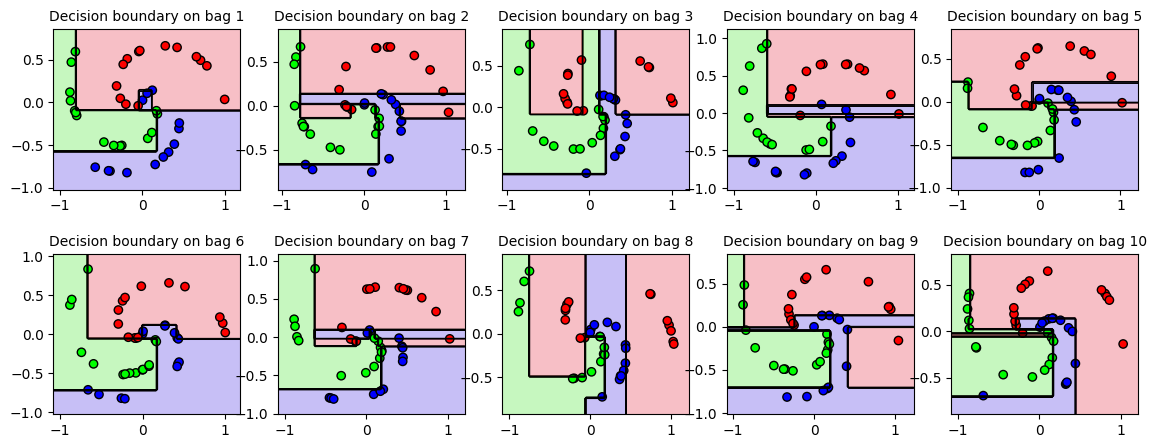

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
N = 200  # number of points per class
D = 2  # dimensionality
K = 3  # number of classes

# Initialize data matrix and class labels
X_bspiral = np.zeros((N * K, D))  # data matrix (each row = single example)
y_bspiral = np.zeros(N * K, dtype='int64')  # class labels

# Generate data points for each class
for j in range(K):
    ix = range(N * j, N * (j + 1))  # indices for this class
    r = np.linspace(0.0, 1, N)  # radius
    r = r + j * 0.05  # increase radius for each class
    t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.02  # theta
    X_bspiral[ix] = np.c_[r * np.sin(t), r * np.cos(t)]  # generate data points
    y_bspiral[ix] = j  # set class labels

# Combine X and y into one array
spiral_data = np.column_stack((X_bspiral, y_bspiral))

# Save data to a CSV file
np.savetxt("spiral3u.csv", spiral_data, delimiter=",", header="x,y,label", comments="", fmt='%.5f')

# Visualize the data
plt.scatter(X_bspiral[:, 0], X_bspiral[:, 1], c=y_bspiral, s=40, cmap='brg')
plt.show()

# Instantiate and train the decision tree
tree_spiral = DecisionTree(10)
root = tree_spiral.fit(X_bspiral, y_bspiral)

# Plot decision boundaries
plotDecisionBoundaries(X_bspiral, y_bspiral, tree_spiral, title="Decision Boundary for Spiral")
plt.show()

classify_DT(X_bspiral, y_bspiral.astype(int), 3, 10, "Concentric Circles")


tree_spiral.print_tree(root)

In [ ]:
# Initialize the DecisionTree
tree_bspiral = DecisionTree(10)
tree_bspiral.fit(X_bspiral, y_bspiral)

# Display the tree
print("\nDecision Tree for Balanced Spiral Dataset:")
tree_bspiral.displayTree()



Decision Tree for Balanced Spiral Dataset:
[Feature 1 <= 0.15, Info Gain=0.2950]
	[Feature 0 <= 0.19, Info Gain=0.2354]
		[Feature 1 <= -0.06, Info Gain=0.3474]
			[Feature 1 <= -0.65, Info Gain=0.8748]
				Leaf: Class=0, Distribution=[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
				Leaf: Class=2, Distribution=[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
			[Feature 0 <= -0.04, Info Gain=0.8111]
				[Feature 0 <= -0.83, Info Gain=0.6610]
					Leaf: Class=2, Distribution=[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
					Leaf: Class=1, Distribution=[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
				[Feature 1 <= -0.01, Info Gain=0.7219]
					Leaf: Class=2, Distribution=[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
					Leaf: Class=0, Distribution=[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
		[Feature 0 <= 0.46, Info Gain=0.5714]
			Leaf: Class=0, Distribution=[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
			Leaf: Class=1, Distribution=[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
	[Feature 0 <= -0.60, Info Gain=0.8089]
		Leaf: Class=2, Distribution=[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
		Leaf: Clas

In [ ]:
# Split the data
X_bspiral_train, X_bspiral_test, y_bspiral_train, y_bspiral_test = train_test_split(X_bspiral, y_bspiral, test_size=0.3, random_state=42)

# Initialize and train the classifier
tree_bspiral = DecisionTree(10)
tree_bspiral.fit(X_bspiral_train, y_bspiral_train)

# Predict on test data
y_bspiral_pred = tree_bspiral.predict(X_bspiral_test)
# Convert probabilities to class labels
y_bspiral_pred = np.argmax(y_bspiral_pred, axis=1)

# Compute accuracy
bspiral_accuracy = accuracy_score(y_bspiral_test, y_bspiral_pred)
print(f"Accuracy for Balanced Spiral Dataset: {bspiral_accuracy:.2f}")


Accuracy for Balanced Spiral Dataset: 0.97


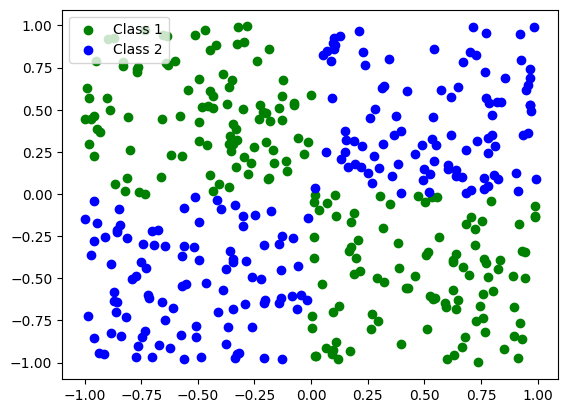

200 200
(400, 2)


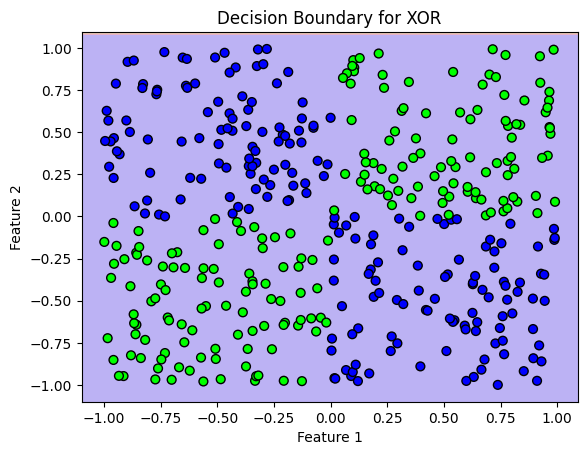

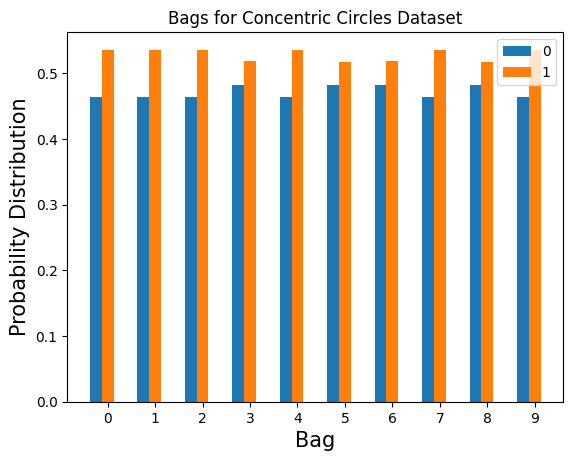

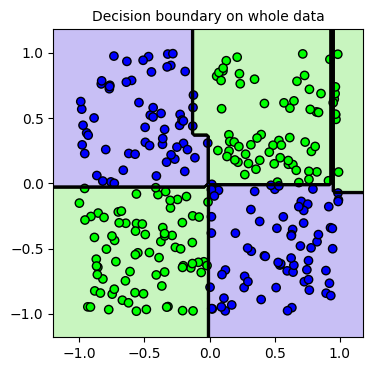

Accuracy in Random forest:  0.8666666666666667
(Internal node) Information Gain= 0.16341629742542163 , Feature= 0 , Threshold= 1.0906003147674648
(Internal node) Information Gain= 0.3258819206128831 , Feature= 0 , Threshold= -1.108860340407103
(Internal node) Information Gain= 0.4765868095885044 , Feature= 0 , Threshold= -2.0927150453084207
(Leaf node) Probability Distribution= [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(Internal node) Information Gain= 0.29874183238676255 , Feature= 1 , Threshold= -2.228932309690911
(Leaf node) Probability Distribution= [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(Internal node) Information Gain= 0.6142910730156772 , Feature= 1 , Threshold= 1.7199969946387506
(Leaf node) Probability Distribution= [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(Leaf node) Probability Distribution= [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(Internal node) Information Gain= 0.3236050228886369 , Feature= 1 , Threshold= -1.6132156524119234
(Internal node) Information Gain= 0.9722080563599758 , Feature= 1 , Threshold= -2

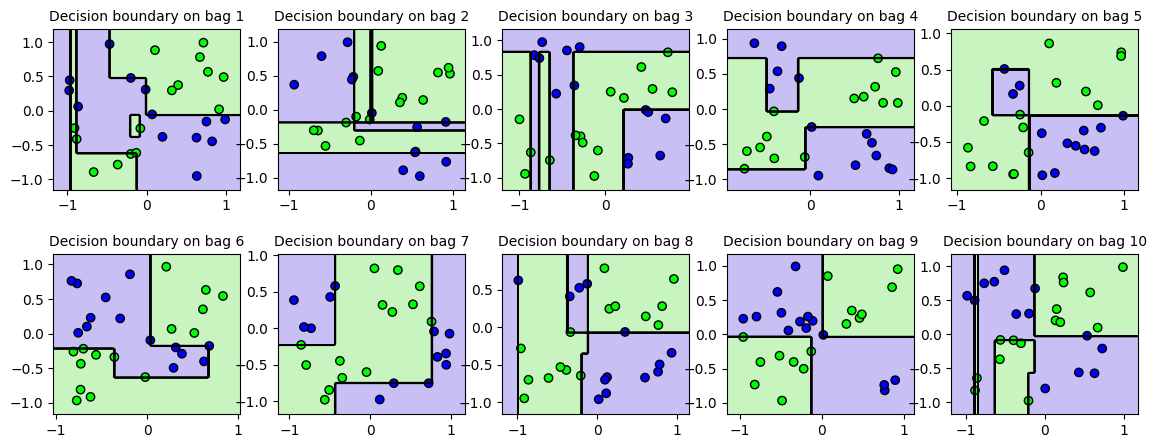

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# Generate data for Class 1
x1 = np.concatenate([np.random.uniform(0, 1, 100), np.random.uniform(-1, 0, 100)])
y1 = np.concatenate([np.random.uniform(-1, 0, 100), np.random.uniform(0, 1, 100)])
label1 = np.zeros_like(x1, dtype=np.int64)  # Create a list of zeros of the same shape as x1 and y1

# Generate data for Class 2
x2 = np.concatenate([np.random.uniform(0, 1, 100), np.random.uniform(-1, 0, 100)])
y2 = np.concatenate([np.random.uniform(0, 1, 100), np.random.uniform(-1, 0, 100)])
label2 = np.ones_like(x2, dtype=np.int64)  # Create a list of ones of the same shape as x2 and y2

# Plotting
plt.scatter(x1, y1, c='green', label='Class 1')  # Scatter plot for Class 1
plt.scatter(x2, y2, c='blue', label='Class 2')  # Scatter plot for Class 2
plt.legend()  # Show legend
plt.show()  # Display the plot

# no of points in class1, class2
print(len(x1), len(x2))
# Prepare the XOR dataset
xorFeatures = np.column_stack((np.concatenate([x1, x2]), np.concatenate([y1, y2])))
xorLabels = np.concatenate([label1, label2])

# Ensure that the feature and label arrays have the same length
assert len(xorFeatures) == len(xorLabels), "Feature and label arrays must have the same length"

# Instantiate and train the decision tree
decisionTreeXor = DecisionTree(10)
print(xorFeatures.shape)
root = decisionTreeXor.fit(XCircles, yCircles)


# Plot decision boundaries
plotDecisionBoundaries(xorFeatures, xorLabels, decisionTreeXor, title="Decision Boundary for XOR")
plt.show()

classify_DT(xorFeatures, xorLabels.astype(int), 2, 10, "Concentric Circles")
decisionTreeXor.print_tree(root)

In [ ]:
# Initialize the DecisionTree
tree_xor = DecisionTree(10)
tree_xor.fit(xorFeatures, xorLabels)

# Display the tree
print("Decision Tree for XOR Dataset:")
tree_xor.displayTree()


Decision Tree for XOR Dataset:
[Feature 0 <= 0.94, Info Gain=0.0074]
	[Feature 1 <= 0.37, Info Gain=0.0125]
		[Feature 0 <= -0.06, Info Gain=0.1069]
			[Feature 1 <= -0.02, Info Gain=0.8344]
				Leaf: Class=1, Distribution=[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
				Leaf: Class=0, Distribution=[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
			[Feature 1 <= -0.00, Info Gain=0.7045]
				[Feature 0 <= -0.01, Info Gain=0.1944]
					Leaf: Class=1, Distribution=[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
					Leaf: Class=0, Distribution=[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
				[Feature 0 <= -0.01, Info Gain=0.3054]
					Leaf: Class=0, Distribution=[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
					Leaf: Class=1, Distribution=[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
		[Feature 0 <= -0.00, Info Gain=0.9580]
			Leaf: Class=0, Distribution=[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
			Leaf: Class=1, Distribution=[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
	[Feature 1 <= -0.07, Info Gain=0.7793]
		Leaf: Class=0, Distribution=[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
		Leaf: Class=1, Distrib

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data
X_xor_train, X_xor_test, y_xor_train, y_xor_test = train_test_split(xorFeatures, xorLabels, test_size=0.3, random_state=42)

# Initialize and train the classifier
tree_xor = DecisionTree(10)
tree_xor.fit(X_xor_train, y_xor_train)

# Predict on test data
y_xor_pred = tree_xor.predict(X_xor_test)
y_xor_pred = np.argmax(y_xor_pred,axis=1)
# Compute accuracy
xor_accuracy = accuracy_score(y_xor_test, y_xor_pred)
print(f"Accuracy for XOR Dataset: {xor_accuracy:.2f}")


Accuracy for XOR Dataset: 0.97


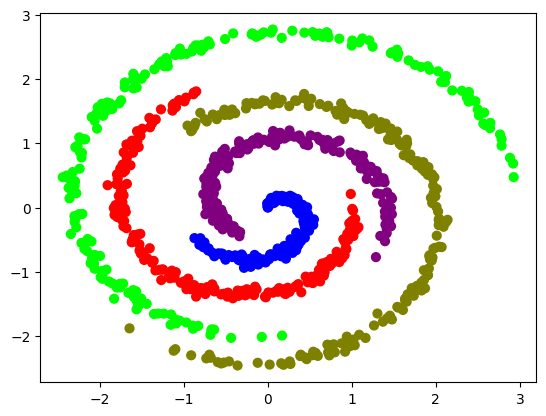

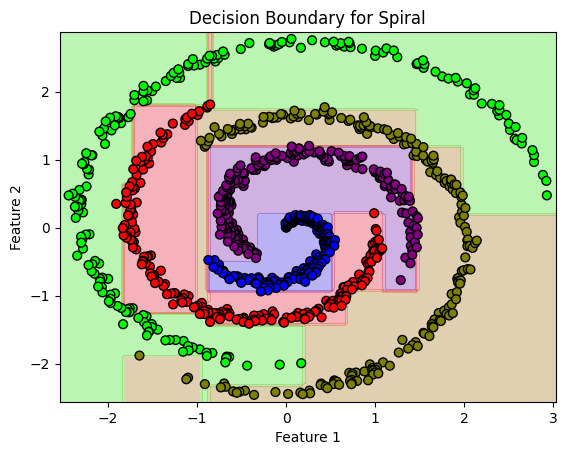

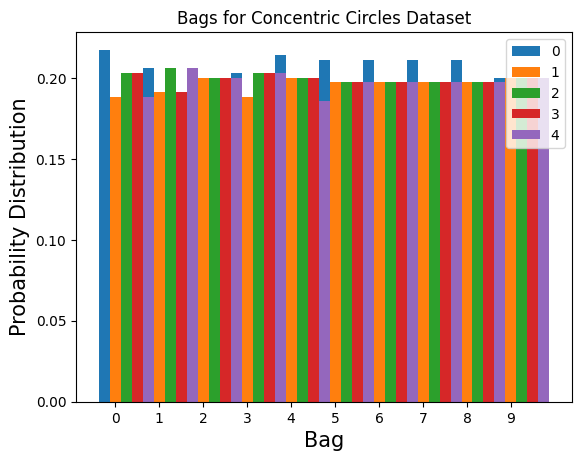

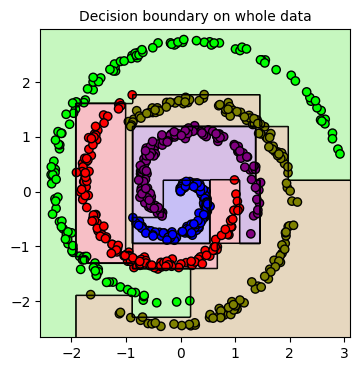

Accuracy in Random forest:  0.82
(Internal node) Information Gain= 0.32658977697713887 , Feature= 0 , Threshold= -0.8749386825910038
(Internal node) Information Gain= 0.3081230398403014 , Feature= 0 , Threshold= -1.8521240988526675
(Internal node) Information Gain= 0.05095689841189607 , Feature= 0 , Threshold= -1.913232619741596
(Leaf node) Probability Distribution= [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(Internal node) Information Gain= 0.5916727785823275 , Feature= 0 , Threshold= -1.9080975143577084
(Leaf node) Probability Distribution= [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(Leaf node) Probability Distribution= [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(Internal node) Information Gain= 0.27973715819240474 , Feature= 1 , Threshold= -1.2850513753700823
(Internal node) Information Gain= 0.47149618869131643 , Feature= 1 , Threshold= -1.8804865920126679
(Internal node) Information Gain= 0.7219280948873623 , Feature= 0 , Threshold= -0.9134216428208991
(Leaf node) Probability Distribution= [0. 0. 0. 1. 0. 0. 0. 0

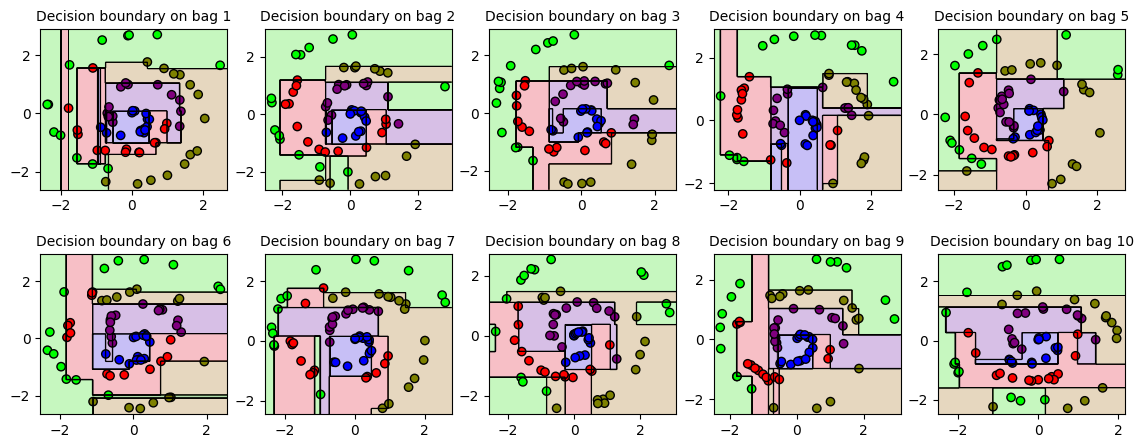

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
N = 200  # number of points per class
D = 2    # dimensionality
K = 5    # number of classes

# Initialize data matrix and labels
X_uspiral = np.zeros((N*K, D))       # data matrix (each row = single example)
y_uspiral = np.zeros(N*K, dtype='int64')  # class labels

# Generate data for each class
for j in range(K):
    # Generate indices for this class
    ix = range(N*j, N*(j+1))

    # Define radius with some variation based on the class index
    r = np.linspace(0.0, 1, N)  # radius
    r = r + j*0.5

    # Generate theta with some noise
    t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N) * 0.2  # theta

    # Convert polar coordinates to Cartesian coordinates and assign to data matrix
    X_uspiral[ix] = np.c_[r*np.sin(t), r*np.cos(t)]

    # Assign class labels
    y_uspiral[ix] = j

# Combine data and labels into a single array
spiral_data = np.column_stack((X_uspiral, y_uspiral))

# Visualize the data
plt.scatter(X_uspiral[:, 0], X_uspiral[:, 1], c=y_uspiral, s=40, cmap='brg')
plt.show()

# Instantiate and train the decision tree
tree_spiral = DecisionTree(10)
root = tree_spiral.fit(X_uspiral, y_uspiral)


# Plot decision boundaries
plotDecisionBoundaries(X_uspiral, y_uspiral, tree_spiral, title="Decision Boundary for Spiral")
plt.show()

classify_DT(X_uspiral, y_uspiral.astype(int), 5, 10, "Concentric Circles")
tree_spiral.print_tree(root)

In [ ]:
# Initialize the DecisionTree
tree_uspiral = DecisionTree(10)
tree_uspiral.fit(X_uspiral, y_uspiral)

# Display the tree
print("\nDecision Tree for Unbalanced Spiral Dataset:")
tree_uspiral.displayTree()



Decision Tree for Unbalanced Spiral Dataset:
[Feature 0 <= -0.87, Info Gain=0.3266]
	[Feature 0 <= -1.85, Info Gain=0.3081]
		[Feature 0 <= -1.91, Info Gain=0.0510]
			Leaf: Class=4, Distribution=[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
			[Feature 0 <= -1.91, Info Gain=0.5917]
				Leaf: Class=2, Distribution=[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
				Leaf: Class=4, Distribution=[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
		[Feature 1 <= -1.29, Info Gain=0.2797]
			[Feature 1 <= -1.88, Info Gain=0.4715]
				[Feature 0 <= -0.91, Info Gain=0.7219]
					Leaf: Class=3, Distribution=[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
					Leaf: Class=4, Distribution=[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
				Leaf: Class=4, Distribution=[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
			[Feature 1 <= 1.79, Info Gain=0.4753]
				[Feature 0 <= -1.72, Info Gain=0.1663]
					[Feature 1 <= -1.18, Info Gain=0.5178]
						Leaf: Class=4, Distribution=[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
						[Feature 1 <= 0.67, Info Gain=0.4395]
							Leaf: Class=2, Distribution=[0. 0. 1

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Assuming you have imported or defined DecisionTree class
# Replace this with the actual DecisionTree class you are using

# Split the data
X_uspiral_train, X_uspiral_test, y_uspiral_train, y_uspiral_test = train_test_split(X_uspiral, y_uspiral, test_size=0.3, random_state=42)

# Initialize and train the classifier
tree_uspiral = DecisionTree(10)
tree_uspiral.fit(X_uspiral_train, y_uspiral_train)

# Predict on test data
y_uspiral_pred_proba = tree_uspiral.predict(X_uspiral_test)

# Convert probabilities to class labels
y_uspiral_pred = np.argmax(y_uspiral_pred_proba, axis=1)

# Compute accuracy
uspiral_accuracy = accuracy_score(y_uspiral_test, y_uspiral_pred)
print(f"Accuracy for Unbalanced Spiral Dataset: {uspiral_accuracy:.2f}")


Accuracy for Unbalanced Spiral Dataset: 0.97


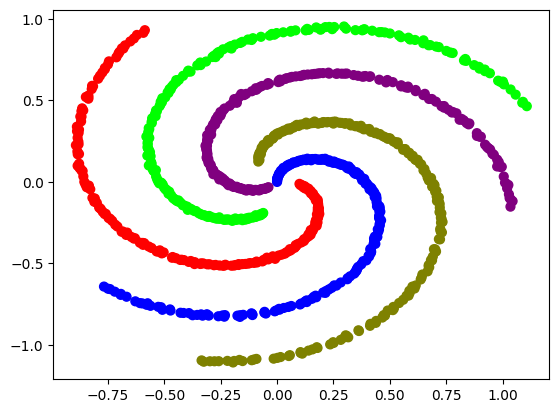

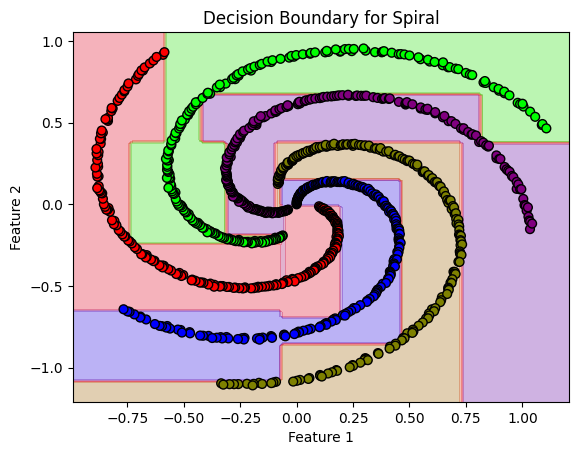

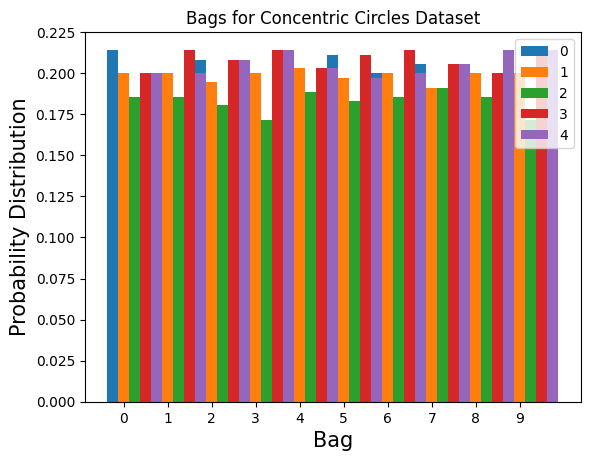

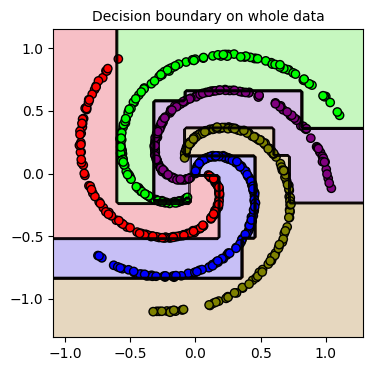

Accuracy in Random forest:  0.85
(Internal node) Information Gain= 0.2509696984460912 , Feature= 1 , Threshold= 0.37162684927722456
(Internal node) Information Gain= 0.3085887811338832 , Feature= 0 , Threshold= -0.06126403234265171
(Internal node) Information Gain= 0.5562168394435054 , Feature= 1 , Threshold= -0.239025842667817
(Internal node) Information Gain= 0.9977724720899823 , Feature= 1 , Threshold= -0.6420651777676578
(Internal node) Information Gain= 0.8189555018403103 , Feature= 1 , Threshold= -1.0858633409224763
(Leaf node) Probability Distribution= [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(Leaf node) Probability Distribution= [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(Leaf node) Probability Distribution= [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(Internal node) Information Gain= 0.6394571324851641 , Feature= 0 , Threshold= -0.7395089873626641
(Leaf node) Probability Distribution= [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(Internal node) Information Gain= 0.4100510046253719 , Feature= 0 , Threshold= -0.32101626339

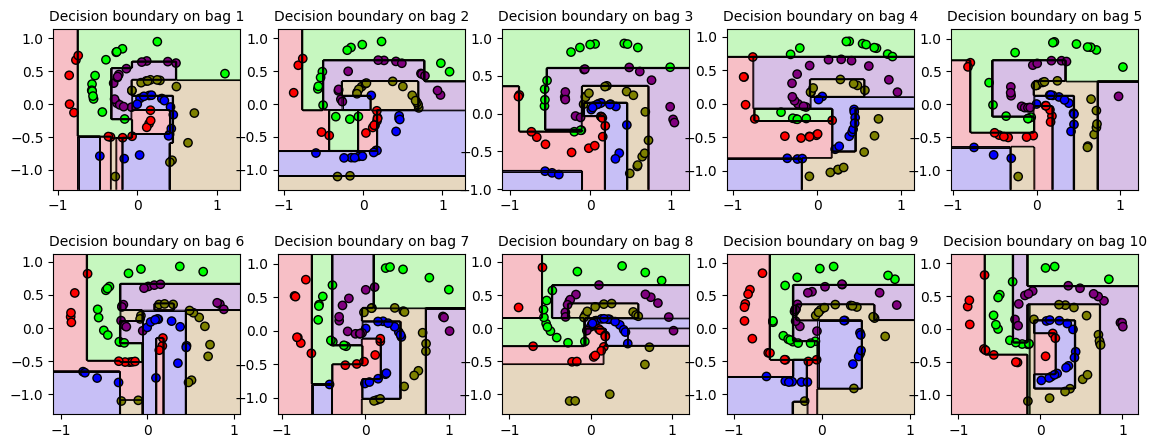

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
N = 200  # number of points per class
D = 2    # dimensionality
K = 5    # number of classes

# Data matrix (each row = single example)
X = np.zeros((N*K, D))

# Class labels
y = np.zeros(N*K, dtype='uint8')

# Generate data
for j in range(K):
    ix = range(N*j, N*(j + 1))

    # Radius
    r = np.linspace(0.0, 1, N)
    r = r + j * 0.05

    # Theta
    t = np.linspace(j*4, (j+1) * 4, N) + np.random.randn(N) * 0.02

    # Fill data matrix
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

# Combine X and y to create the dataset
spiral5 = np.column_stack((X, y))

# Visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='brg')
plt.show()



# Instantiate and train the decision tree
tree_spiral = DecisionTree(10)
root = tree_spiral.fit(X, y)

# Plot decision boundaries
plotDecisionBoundaries(X, y, tree_spiral, title="Decision Boundary for Spiral")
plt.show()

classify_DT(X, y.astype(int), 5, 10, "Concentric Circles")

tree_spiral.print_tree(root)

In [ ]:
# Initialize the DecisionTree
tree = DecisionTree(10)
tree.fit(X, y)

# Display the tree
print("\nDecision Tree for balanced Spiral Dataset:")
tree.displayTree()



Decision Tree for Unbalanced Spiral Dataset:
[Feature 1 <= 0.37, Info Gain=0.2510]
	[Feature 0 <= -0.06, Info Gain=0.3086]
		[Feature 1 <= -0.24, Info Gain=0.5562]
			[Feature 1 <= -0.64, Info Gain=0.9978]
				[Feature 1 <= -1.09, Info Gain=0.8190]
					Leaf: Class=3, Distribution=[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
					Leaf: Class=0, Distribution=[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
				Leaf: Class=2, Distribution=[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
			[Feature 0 <= -0.74, Info Gain=0.6395]
				Leaf: Class=2, Distribution=[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
				[Feature 0 <= -0.32, Info Gain=0.4101]
					Leaf: Class=4, Distribution=[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
					[Feature 1 <= -0.19, Info Gain=0.8571]
						Leaf: Class=4, Distribution=[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
						[Feature 0 <= -0.09, Info Gain=0.4652]
							Leaf: Class=1, Distribution=[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
							[Feature 1 <= -0.04, Info Gain=0.8113]
								Leaf: Class=1, Distribution=[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
						

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the classifier
tree = DecisionTree(10)
tree.fit(X_train, y_train)

# Predict on test data
y_pred = tree.predict(X_test)
y_pred = np.argmax(y_pred , axis=1)

# Compute accuracy
uspiral_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for Unbalanced Spiral Dataset: {uspiral_accuracy:.2f}")


Accuracy for Unbalanced Spiral Dataset: 0.96
